### Import Libraries

In [1]:
!pip install -q kaggle
!pip install torchinfo

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir kaggle
!cp kaggle.json kaggle/
!chmod 600 /content/kaggle/kaggle.json
!kaggle datasets list

### Dataset

Download Dataset

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip /content/chest-xray-pneumonia.zip

Get Image Counts

In [15]:
''' This function will get the file counts given path to dataset'''
def count_files_in_subfolders(main_dir):
    subfolders = ['train', 'val', 'test']
    results = {}

    for subfolder in subfolders:
        path = os.path.join(main_dir, subfolder)
        class_dirs = ['0', '1']
        counts = {}

        for class_dir in class_dirs:
            class_path = os.path.join(path, class_dir)
            file_count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            counts[class_dir] = file_count

        results[subfolder] = counts

    return results

In [17]:
# ----- INSERT PATH TO DATA HERE -----
# NOTE: Inside each train/val/test folder is a folder for each class: NOMRAL and PNEUMONIA
# I had to manually rename all the folders to 0 and 1
# NORMAL -->change to-->  0
# PNEUMONIA -->change to-->  1
main_directory = "/content/chest_xray"
file_counts = count_files_in_subfolders(main_directory)

for k, v in file_counts.items():
    print(k, v)

train {'0': 1341, '1': 3875}
val {'0': 8, '1': 8}
test {'0': 234, '1': 390}


Set up dataloader

In [18]:
'''This class creates a custom dataloader that will be used
   by all models during training and testing. The use_percentage
   parameter can be set to use different percent of samples'''
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None, use_percentage=100):
        self.directory = directory
        self.transform = transform
        self.samples = []

        # Navigate through both class directories '0' and '1'
        for label in ['0', '1']:
            label_dir = os.path.join(self.directory, label)
            for img_file in os.listdir(label_dir):
                self.samples.append((os.path.join(label_dir, img_file), int(label)))

        # Shuffle the samples to ensure random selection
        random.shuffle(self.samples)

        # Reduce the number of samples based on the percentage specified
        if use_percentage < 100:
            num_samples = int(len(self.samples) * (use_percentage / 100.0))
            self.samples = self.samples[:num_samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB

        if self.transform:
            image = self.transform(image)

        return image, label

Plot sample images

In [19]:
''' The functions in this cell are used to plot sample images'''
def imshow(img):
    # Un-normalize the image for displaying
    img = img / 2 + 0.5  # undo the normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_images(data_loader):
    # Get a batch of images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Create a 3x3 grid for the images
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.3)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [26]:
''' Create an example instance of dataloader to see if it is working and plot sample images'''
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
ex_dataset = ImageDataset(directory=os.path.join(main_directory, 'test'), transform=transform)
ex_loader = DataLoader(ex_dataset, batch_size=9, shuffle=True, num_workers=4)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


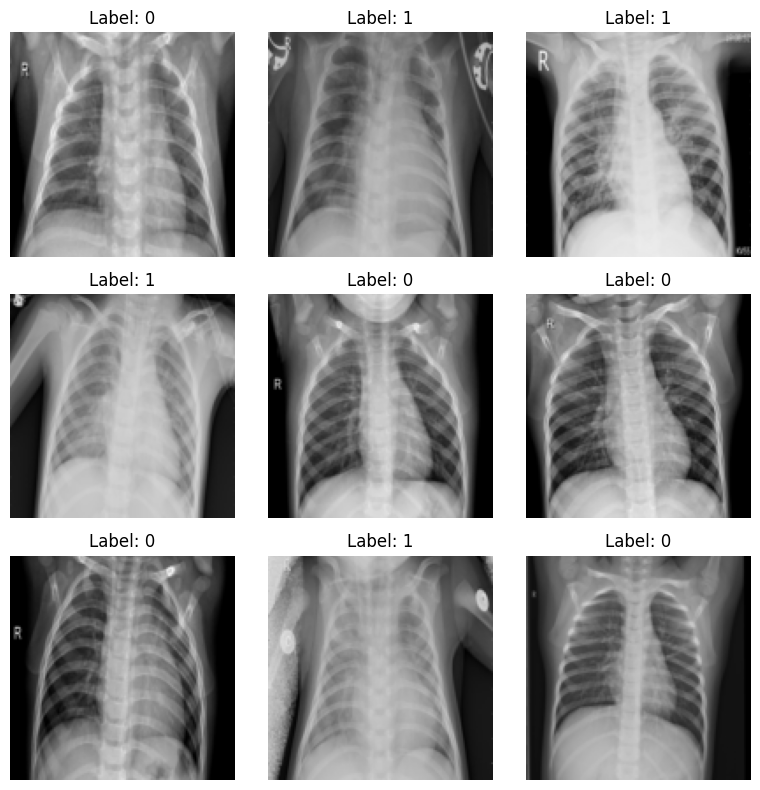

In [27]:
plot_images(ex_loader)

### Set up Models

In [4]:
"""A simple convolutional block: Convolution + BatchNorm + ReLU."""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

"""Standard residual block with two convolutional layers."""
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn(self.conv2(out))
        out += residual
        return self.relu(out)

"""ODE function block with a convolutional layer."""
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.conv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

"""ODE Block applying the specified numerical method for integration."""
class ODEBlock(nn.Module):
    def __init__(self, odefunc, method='rk4', step_size=0.1):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.method = method
        self.step_size = step_size

    def forward(self, x):
        dt = self.step_size
        if self.method == 'euler':
            return self.euler_step(x, dt)
        elif self.method == 'rk4':
            return self.rk4_step(x, dt)

    def euler_step(self, x, dt):
        return x + self.odefunc(x) * dt

    def rk4_step(self, x, dt):
        k1 = self.odefunc(x)
        k2 = self.odefunc(x + dt / 2 * k1)
        k3 = self.odefunc(x + dt / 2 * k2)
        k4 = self.odefunc(x + dt * k3)
        return x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [5]:
''' ======== FINAL ODE MODEL ========'''
class MultiODEBlock(nn.Module):
    def __init__(self, method='rk4'):
        super(MultiODEBlock, self).__init__()
        self.conv1 = ConvBlock(3, 16, stride=1)
        self.conv2 = ConvBlock(16, 32, stride=2)

        # Adding multiple ODE blocks
        self.odeblock1 = ODEBlock(ODEFunc(32), method=method, step_size=0.1)
        self.odeblock2 = ODEBlock(ODEFunc(32), method=method, step_size=0.1)
        self.odeblock3 = ODEBlock(ODEFunc(32), method=method, step_size=0.1)
        self.odeblock4 = ODEBlock(ODEFunc(32), method=method, step_size=0.1)

        self.conv3 = ConvBlock(32, 64, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.odeblock1(x)
        x = self.odeblock2(x)
        x = self.odeblock3(x)
        x = self.odeblock4(x)

        x = self.conv3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [6]:
''' ======== FINAL RESIDUAL MODEL ========'''
class MultiResBlock(nn.Module):
    def __init__(self):
        super(MultiResBlock, self).__init__()
        self.conv1 = ConvBlock(3, 16, stride=1)
        self.conv2 = ConvBlock(16, 32, stride=2)

        # Adding multiple Residual blocks
        self.resblock1 = ResidualBlock(32)
        self.resblock2 = ResidualBlock(32)
        self.resblock3 = ResidualBlock(32)
        self.resblock4 = ResidualBlock(32)

        self.conv3 = ConvBlock(32, 64, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)

        x = self.conv3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [12]:
# Get Model summary
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiODEBlock(method='euler').to(device)
#model = MultiResBlock().to(device)
summary(model, input_size=(64, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MultiODEBlock                            [64, 1]                   --
├─ConvBlock: 1-1                         [64, 16, 128, 128]        --
│    └─Conv2d: 2-1                       [64, 16, 128, 128]        448
│    └─BatchNorm2d: 2-2                  [64, 16, 128, 128]        32
│    └─ReLU: 2-3                         [64, 16, 128, 128]        --
├─ConvBlock: 1-2                         [64, 32, 64, 64]          --
│    └─Conv2d: 2-4                       [64, 32, 64, 64]          4,640
│    └─BatchNorm2d: 2-5                  [64, 32, 64, 64]          64
│    └─ReLU: 2-6                         [64, 32, 64, 64]          --
├─ODEBlock: 1-3                          [64, 32, 64, 64]          --
│    └─ODEFunc: 2-7                      [64, 32, 64, 64]          --
│    │    └─Conv2d: 3-1                  [64, 32, 64, 64]          9,216
│    │    └─BatchNorm2d: 3-2             [64, 32, 64, 64]          64
│    │  

### Train Model

In [84]:
# Device Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
#model_res = MultiResBlock().to(device)
#model_rk4 = MultiODEBlock(method='rk4').to(device)
model_euler = MultiODEBlock(method='euler').to(device)

# Hyperparameters
batch_size = 64
epochs = 5
lr = 0.001

# DataLoader
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = ImageDataset(directory=os.path.join(main_directory, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = ImageDataset(directory=os.path.join(main_directory, 'val'), transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_euler.parameters(), lr=lr)

def train_and_validate(model, train_loader, valid_loader, epochs, criterion, optimizer):
    # Lists to hold losses for plotting
    train_losses = []
    val_losses = []
    avg_train_losses = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        batch_losses = []

        # ========== Training ==========
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())

            if i % 20 == 19:  # Log after every 50 batches
                avg_loss = running_loss / 20
                print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {avg_loss:.3f}')
                avg_train_losses.append(avg_loss)
                running_loss = 0.0

        # ========== Validation ==========
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)

        print(f'End of Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.3f}')

    return avg_train_losses, val_losses

In [75]:
# Res - time taken was 6 min 17 sec
avg_train_losses_res, val_losses_res = train_and_validate(model_res, train_loader, valid_loader,
                                                          epochs, criterion, optimizer)

[Epoch: 1, Batch: 20] Loss: 0.504
[Epoch: 1, Batch: 40] Loss: 0.377
[Epoch: 1, Batch: 60] Loss: 0.342
[Epoch: 1, Batch: 80] Loss: 0.303
End of Epoch 1, Validation Loss: 5.113
[Epoch: 2, Batch: 20] Loss: 1.126
[Epoch: 2, Batch: 40] Loss: 0.582
[Epoch: 2, Batch: 60] Loss: 0.554
[Epoch: 2, Batch: 80] Loss: 0.549
End of Epoch 2, Validation Loss: 0.894
[Epoch: 3, Batch: 20] Loss: 0.540
[Epoch: 3, Batch: 40] Loss: 0.539
[Epoch: 3, Batch: 60] Loss: 0.541
[Epoch: 3, Batch: 80] Loss: 0.560
End of Epoch 3, Validation Loss: 0.880
[Epoch: 4, Batch: 20] Loss: 0.562
[Epoch: 4, Batch: 40] Loss: 0.539
[Epoch: 4, Batch: 60] Loss: 0.522
[Epoch: 4, Batch: 80] Loss: 0.514
End of Epoch 4, Validation Loss: 1.150
[Epoch: 5, Batch: 20] Loss: 0.489
[Epoch: 5, Batch: 40] Loss: 0.485
[Epoch: 5, Batch: 60] Loss: 0.484
[Epoch: 5, Batch: 80] Loss: 0.405
End of Epoch 5, Validation Loss: 0.917


In [82]:
# RK4 - time taken was 6 min 37 sec
avg_train_losses_rk4, val_losses_rk4 = train_and_validate(model_rk4, train_loader, valid_loader,
                                                          epochs, criterion, optimizer)

[Epoch: 1, Batch: 20] Loss: 0.514
[Epoch: 1, Batch: 40] Loss: 0.426
[Epoch: 1, Batch: 60] Loss: 0.362
[Epoch: 1, Batch: 80] Loss: 0.342
End of Epoch 1, Validation Loss: 0.513
[Epoch: 2, Batch: 20] Loss: 0.554
[Epoch: 2, Batch: 40] Loss: 0.394
[Epoch: 2, Batch: 60] Loss: 0.377
[Epoch: 2, Batch: 80] Loss: 0.280
End of Epoch 2, Validation Loss: 0.900
[Epoch: 3, Batch: 20] Loss: 0.271
[Epoch: 3, Batch: 40] Loss: 0.317
[Epoch: 3, Batch: 60] Loss: 0.307
[Epoch: 3, Batch: 80] Loss: 0.287
End of Epoch 3, Validation Loss: 1.152
[Epoch: 4, Batch: 20] Loss: 0.274
[Epoch: 4, Batch: 40] Loss: 0.263
[Epoch: 4, Batch: 60] Loss: 0.246
[Epoch: 4, Batch: 80] Loss: 0.282
End of Epoch 4, Validation Loss: 0.606
[Epoch: 5, Batch: 20] Loss: 0.287
[Epoch: 5, Batch: 40] Loss: 0.246
[Epoch: 5, Batch: 60] Loss: 0.256
[Epoch: 5, Batch: 80] Loss: 0.243
End of Epoch 5, Validation Loss: 0.891


In [85]:
# euler - time taken was 6 min 20 sec
avg_train_losses, val_losses = train_and_validate(model_euler, train_loader, valid_loader,
                                                  epochs, criterion, optimizer)

[Epoch: 1, Batch: 20] Loss: 0.552
[Epoch: 1, Batch: 40] Loss: 0.417
[Epoch: 1, Batch: 60] Loss: 0.359
[Epoch: 1, Batch: 80] Loss: 0.353
End of Epoch 1, Validation Loss: 1.144
[Epoch: 2, Batch: 20] Loss: 0.563
[Epoch: 2, Batch: 40] Loss: 0.511
[Epoch: 2, Batch: 60] Loss: 0.370
[Epoch: 2, Batch: 80] Loss: 0.291
End of Epoch 2, Validation Loss: 0.908
[Epoch: 3, Batch: 20] Loss: 0.356
[Epoch: 3, Batch: 40] Loss: 0.309
[Epoch: 3, Batch: 60] Loss: 0.290
[Epoch: 3, Batch: 80] Loss: 0.304
End of Epoch 3, Validation Loss: 1.088
[Epoch: 4, Batch: 20] Loss: 0.272
[Epoch: 4, Batch: 40] Loss: 0.298
[Epoch: 4, Batch: 60] Loss: 0.279
[Epoch: 4, Batch: 80] Loss: 0.258
End of Epoch 4, Validation Loss: 1.018
[Epoch: 5, Batch: 20] Loss: 0.265
[Epoch: 5, Batch: 40] Loss: 0.268
[Epoch: 5, Batch: 60] Loss: 0.250
[Epoch: 5, Batch: 80] Loss: 0.245
End of Epoch 5, Validation Loss: 1.147


### Test Model

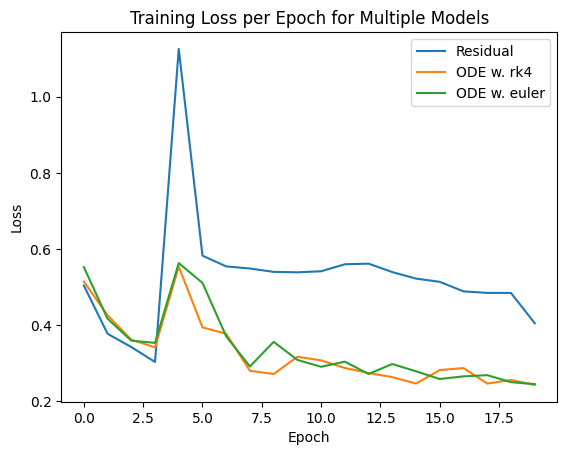

In [94]:
# Plot the losses
losses = [avg_train_losses_res, avg_train_losses_rk4, avg_train_losses]
plt.rcdefaults()
plt.figure()
for l, name in zip(losses, ['Residual', 'ODE w. rk4', 'ODE w. euler']):
  plt.plot(l, label=name)
plt.legend()
plt.title('Training Loss per Epoch for Multiple Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Optimal Threshold for model Residual: 0.67
Confusion Matrix for model Residual:
[[ 54 180]
 [  3 387]]
Accuracy for model Residual: 70.67%
Optimal Threshold for model ODE w. rk4: 0.70
Confusion Matrix for model ODE w. rk4:
[[176  58]
 [ 46 344]]
Accuracy for model ODE w. rk4: 83.33%
Optimal Threshold for model ODE w. euler: 0.83
Confusion Matrix for model ODE w. euler:
[[171  63]
 [ 46 344]]
Accuracy for model ODE w. euler: 82.53%


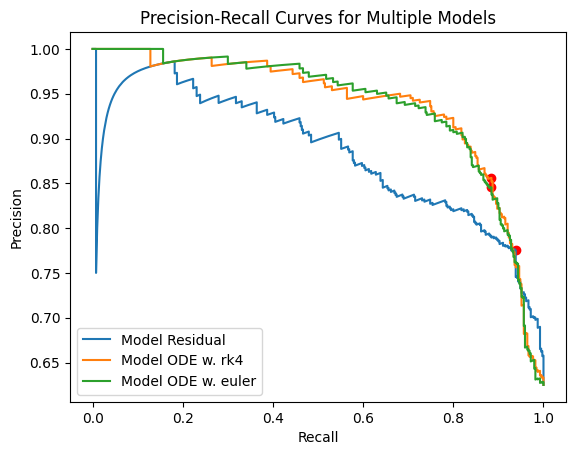

In [86]:
''' The function will help with getting the PR curve, accuracy, and confusion matrix'''
def evaluate_models(models, model_names, test_loader, device):
    plt.rcdefaults()
    plt.figure()
    plt.title('Precision-Recall Curves for Multiple Models')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.rcdefaults()  # Reset default parameters for plotting

    results = []

    for i, model in enumerate(models):
        model.eval()
        all_probabilities = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images).squeeze()
                probabilities = torch.sigmoid(logits)
                all_probabilities.extend(probabilities.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute precision, recall, and thresholds
        precision, recall, thresholds = precision_recall_curve(all_labels, all_probabilities)
        f1_scores = 2 * (recall * precision) / (recall + precision)  # Calculate F1 scores for each threshold

        # Find the index of the highest F1 score
        optimal_idx = np.nanargmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]

        print(f'Optimal Threshold for model {model_names[i]}: {optimal_threshold:.2f}')
        all_probabilities = np.array(all_probabilities)

        # Apply the optimal threshold
        if i==0:
          predictions = (all_probabilities > 0.5).astype(int)
        else:
          predictions = (all_probabilities > optimal_threshold).astype(int)

        # Calculate confusion matrix and accuracy
        cm = confusion_matrix(all_labels, predictions)
        accuracy = accuracy_score(all_labels, predictions)

        print(f'Confusion Matrix for model {model_names[i]}:')
        print(cm)
        print(f'Accuracy for model {model_names[i]}: {accuracy * 100:.2f}%')

        # Plot the PR Curve for each model
        plt.plot(recall, precision, label=f'Model {model_names[i]}')
        plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='red')  # Mark the optimal point

        # Collect results
        results.append((optimal_threshold, cm, accuracy))

    plt.legend()
    plt.show()

    return results

test_dataset = ImageDataset(directory=os.path.join(main_directory, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

models = [model_res, model_rk4, model_euler]
results = evaluate_models(models, ['Residual', 'ODE w. rk4', 'ODE w. euler'], test_loader, device)

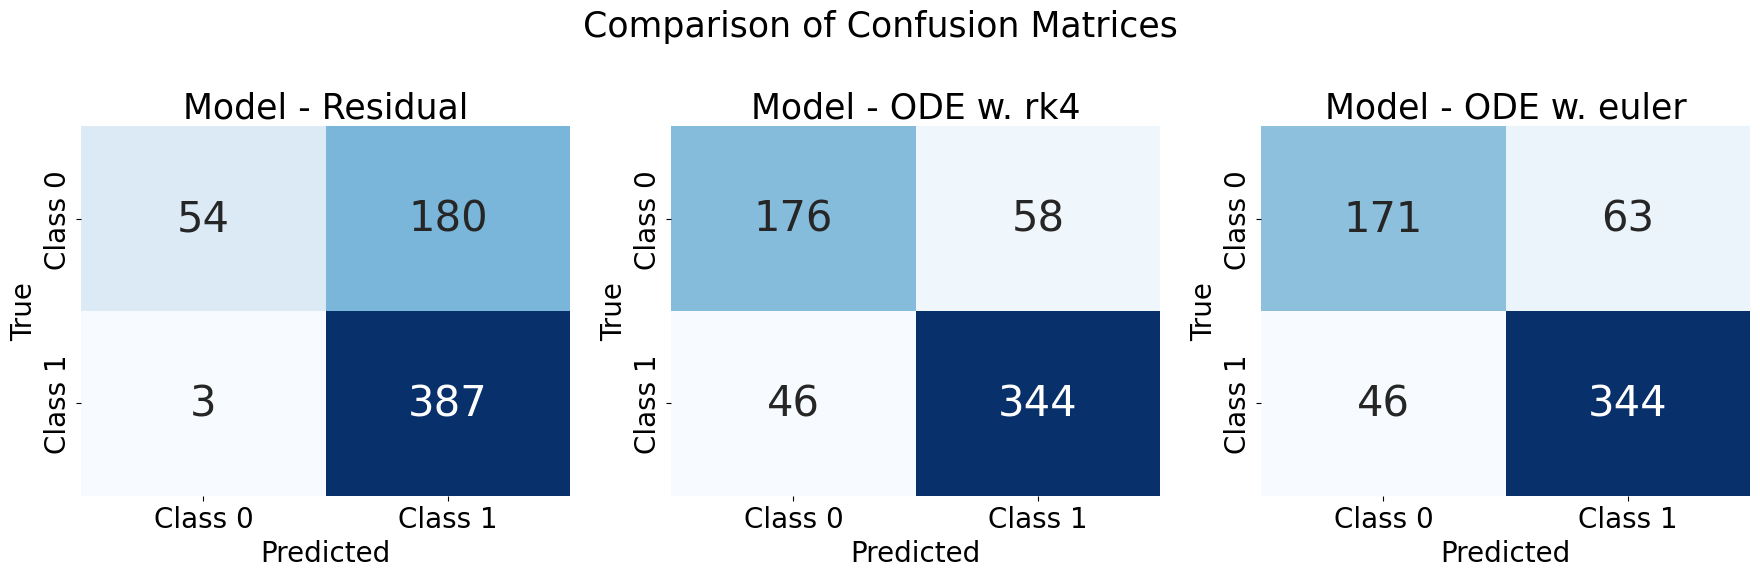

In [108]:
# Setup figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparison of Confusion Matrices', fontsize=25)

for (result, name), ax in zip(zip(results, ['Residual', 'ODE w. rk4', 'ODE w. euler']), axes):
    # Get the confusion matrix
    confusion_matrix = result[1]

    # Create a heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'],
                annot_kws={"size": 30}, ax=ax)

    # Set titles and labels
    ax.set_title(f'Model - {name}', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_ylabel('True', fontsize=20)


plt.tight_layout()
plt.show()


### Inference

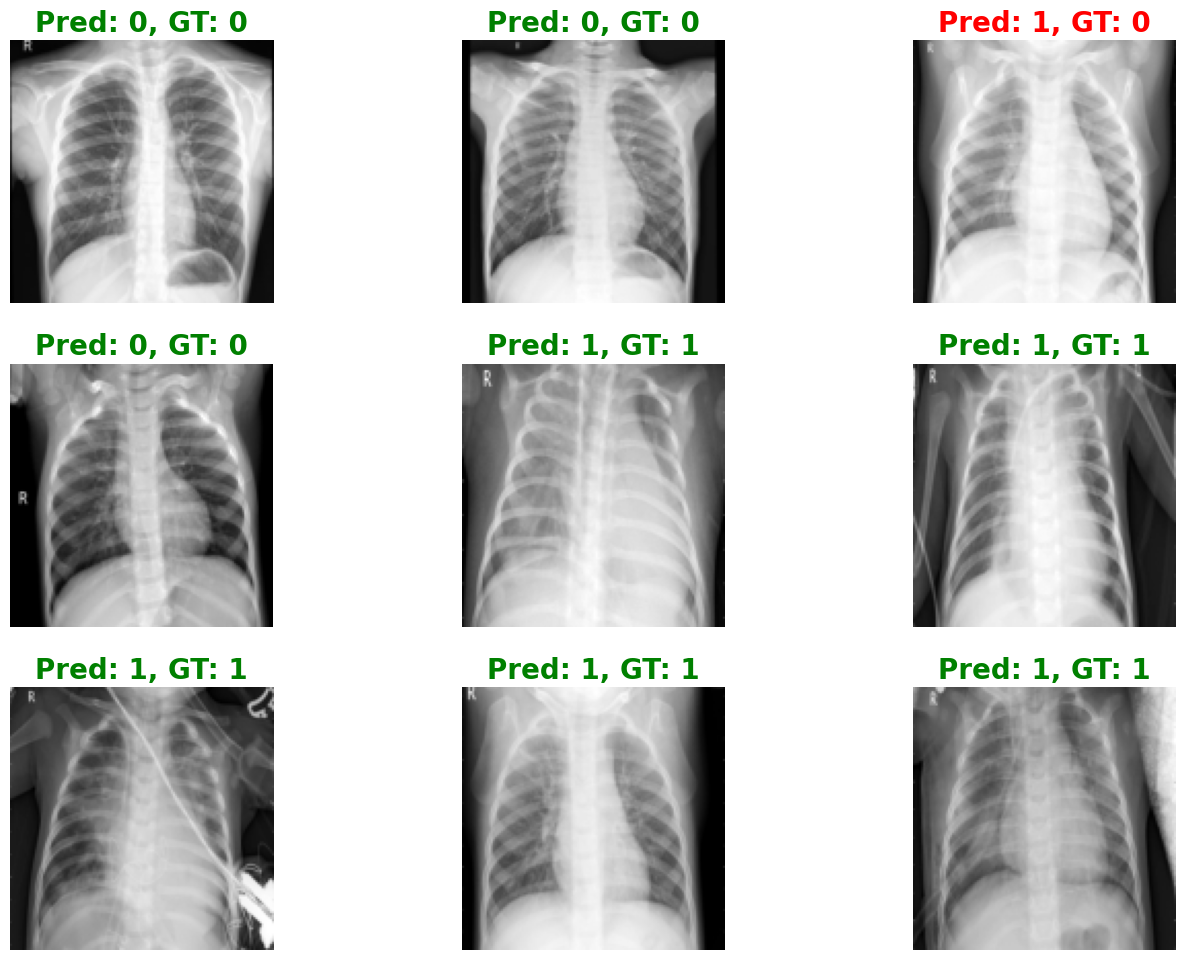

In [111]:
# Initialize lists to keep track of selected indices for each label
selected_indices = {0: [], 1: []}

with torch.no_grad():
    model_rk4.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model_rk4(images).squeeze()
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities > results[1][0]).long()

        # Move tensors to CPU for processing
        images = images.cpu()
        labels = labels.cpu()
        predictions = predictions.cpu()

        # Collect indices until we have the desired balance
        for idx in range(len(labels)):
            label = labels[idx].item()
            if len(selected_indices[label]) < (5 if label == 1 else 4):
                selected_indices[label].append(idx)

            # Check if we have enough images
            if len(selected_indices[0]) >= 4 and len(selected_indices[1]) >= 5:
                break

        if len(selected_indices[0]) >= 4 and len(selected_indices[1]) >= 5:
            break

    if len(selected_indices[0]) >= 4 and len(selected_indices[1]) >= 5:
        # Determine the number of images to plot
        num_images = 9
        num_cols = int(np.sqrt(num_images))
        num_rows = (num_images + num_cols - 1) // num_cols  # Round up to ensure all images fit

        plt.figure(figsize=(15, 10))
        plot_indices = selected_indices[0] + selected_indices[1][:5]  # Use only the first 5 from label 1 if more were collected

        for i, idx in enumerate(plot_indices):
            plt.subplot(num_rows, num_cols, i + 1)
            img = images[idx].numpy().transpose((1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] for displaying
            plt.imshow(img)

            # Determine title color based on prediction accuracy
            title_color = 'green' if predictions[idx].item() == labels[idx].item() else 'red'
            plt.title(f'Pred: {predictions[idx].item()}, GT: {labels[idx].item()}',
                      color=title_color, fontsize=20, fontweight='bold')  # Increase font size and make it bold
            plt.axis('off')

        plt.subplots_adjust()
        plt.tight_layout()
        plt.show()
